# Conditional Average Treatment Effects (CATE) with DoWhy and EconML

This is an experimental feature where we use [EconML](https://github.com/microsoft/econml) methods from DoWhy. Using EconML allows CATE estimation using different methods. 

All four steps of causal inference in DoWhy remain the same: model, identify, estimate, and refute. The key difference is that we now call econml methods in the estimation step. There is also a simpler example using linear regression to understand the intuition behind CATE estimators. 

All datasets are generated using linear structural equations.



In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import logging

import dowhy
from dowhy import CausalModel
import dowhy.datasets

import econml
import warnings
warnings.filterwarnings('ignore')

BETA = 10

keywords are unexpanded, not using


In [3]:
data = dowhy.datasets.linear_dataset(BETA, num_common_causes=4, num_samples=10000,
                                    num_instruments=2, num_effect_modifiers=2,
                                     num_treatments=1,
                                    treatment_is_binary=False,
                                    num_discrete_common_causes=2,
                                    num_discrete_effect_modifiers=0,
                                    one_hot_encode=False)
df=data['df']
print(df.head())
print("True causal estimate is", data["ate"])

         X0        X1   Z0        Z1        W0        W1 W2 W3         v0  \
0 -0.677431 -1.297941  0.0  0.752947 -0.095728  0.180260  0  2  11.952846   
1 -0.794840  0.073329  0.0  0.916845 -0.061684  1.218295  1  2  20.277742   
2 -0.475339  0.877976  0.0  0.779796 -0.548971  2.202832  2  3  21.959953   
3 -0.665753 -3.311659  0.0  0.891187  0.382217  1.778809  3  0  23.656168   
4 -1.135992 -0.483622  0.0  0.874130  1.377125 -0.092371  0  2  18.465844   

            y  
0   36.534667  
1  162.805704  
2  277.179066  
3 -111.290313  
4   81.880818  
True causal estimate is 4.377664456086472


In [4]:
model = CausalModel(data=data["df"], 
                    treatment=data["treatment_name"], outcome=data["outcome_name"], 
                    graph=data["gml_graph"])

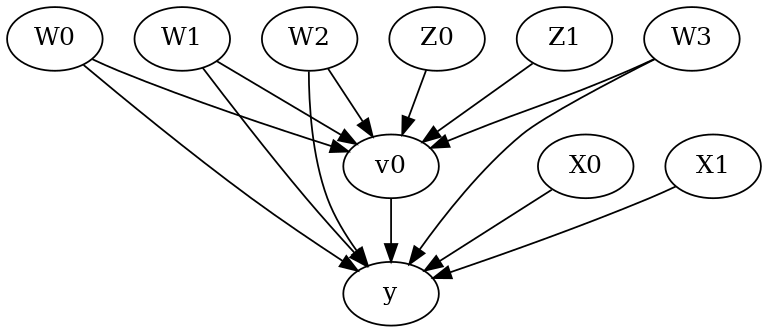

In [5]:
model.view_model()
from IPython.display import Image, display
display(Image(filename="causal_model.png"))

In [6]:
identified_estimand= model.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand)

Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                    
─────(E[y|W1,W0,W3,W2])
d[v₀]                  
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W1,W0,W3,W2,U) = P(y|v0,W1,W0,W3,W2)

### Estimand : 2
Estimand name: iv
Estimand expression:
 ⎡                              -1⎤
 ⎢    d        ⎛    d          ⎞  ⎥
E⎢─────────(y)⋅⎜─────────([v₀])⎟  ⎥
 ⎣d[Z₀  Z₁]    ⎝d[Z₀  Z₁]      ⎠  ⎦
Estimand assumption 1, As-if-random: If U→→y then ¬(U →→{Z0,Z1})
Estimand assumption 2, Exclusion: If we remove {Z0,Z1}→{v0}, then ¬({Z0,Z1}→y)

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



## Linear Model 
First, let us build some intuition using a linear model for estimating CATE. The effect modifiers (that lead to a heterogeneous treatment effect) can be modeled as interaction terms with the treatment. Thus, their value modulates the effect of treatment. 

Below the estimated effect of changing treatment from 0 to 1. 

In [7]:
linear_estimate = model.estimate_effect(identified_estimand, 
                                        method_name="backdoor.linear_regression",
                                       control_value=0,
                                       treatment_value=1)
print(linear_estimate) 

linear_regression
{'control_value': 0, 'treatment_value': 1, 'test_significance': None, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['X1', 'X0']}


*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                    
─────(E[y|W1,W0,W3,W2])
d[v₀]                  
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W1,W0,W3,W2,U) = P(y|v0,W1,W0,W3,W2)

## Realized estimand
b: y~v0+W1+W0+W3+W2+v0*X1+v0*X0
Target units: ate

## Estimate
Mean value: 4.3775936693481885
### Conditional Estimates
__categorical__X1  __categorical__X0
(-5.038, -1.708]   (-4.339, -1.444]     -5.994424
                   (-1.444, -0.847]     -2.816235
                   (-0.847, -0.334]     -1.029346
                   (-0.334, 0.237]       0.971241
                   (0.237, 3.376]        3.916749
(-1.708, -1.144]   (-4.339, -1.444]     -2.527464
                   (-1.444, -0.847]      0.424887
                   (-0.847, -0.334]      2.318873
                   (-0.334, 0.237]       4.241475
                   (0.237, 3.376]        7.3524

## EconML methods
We now move to the more advanced methods from the EconML package for estimating CATE.

First, let us look at the double machine learning estimator. Method_name corresponds to the fully qualified name of the class that we want to use. For double ML, it is "econml.dml.DML". 

Target units defines the units over which the causal estimate is to be computed. This can be a lambda function filter on the original dataframe, a new Pandas dataframe, or a string corresponding to the three main kinds of target units ("ate", "att" and "atc"). Below we show an example of a lambda function. 

Method_params are passed directly to EconML. For details on allowed parameters, refer to the EconML documentation. 

In [8]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LassoCV
from sklearn.ensemble import GradientBoostingRegressor
dml_estimate = model.estimate_effect(identified_estimand, method_name="backdoor.econml.dml.DML",
                                     control_value = 0,
                                     treatment_value = 1,
                                 target_units = lambda df: df["X0"]>1,  # condition used for CATE
                                 confidence_intervals=False,
                                method_params={"init_params":{'model_y':GradientBoostingRegressor(),
                                                              'model_t': GradientBoostingRegressor(),
                                                              "model_final":LassoCV(fit_intercept=False), 
                                                              'featurizer':PolynomialFeatures(degree=1, include_bias=False)},
                                               "fit_params":{}})
print(dml_estimate)

*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                    
─────(E[y|W1,W0,W3,W2])
d[v₀]                  
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W1,W0,W3,W2,U) = P(y|v0,W1,W0,W3,W2)

## Realized estimand
b: y~v0+W1+W0+W3+W2 | X1,X0
Target units: Data subset defined by a function

## Estimate
Mean value: 11.785525783038182
Effect estimates: [ 7.47244463 15.03998427 10.82340778 13.8970306   5.1200387  19.84082476
 12.94613437  8.19017323  7.42408626 12.44918906  9.11438746  1.14633214
 16.7841944  11.23447168 11.88772509 20.58722452  8.27122099 10.7898493
 13.86414674 21.03104832 14.34168707 13.44237971 12.55993099 16.37231211
  5.70982262  3.30265433  9.45004708 16.82841106 18.85910489 11.5171695
 14.76751498 18.45133113  2.79486538 18.36452926 13.10388162  5.97730311
  9.87793849 10.50994725  9.36583033 18.80159757  9.75806558  5.3336776
 14.9701

In [9]:
print("True causal estimate is", data["ate"])

True causal estimate is 4.377664456086472


In [10]:
dml_estimate = model.estimate_effect(identified_estimand, method_name="backdoor.econml.dml.DML",
                                     control_value = 0,
                                     treatment_value = 1,
                                 target_units = 1,  # condition used for CATE
                                 confidence_intervals=False,
                                method_params={"init_params":{'model_y':GradientBoostingRegressor(),
                                                              'model_t': GradientBoostingRegressor(),
                                                              "model_final":LassoCV(fit_intercept=False), 
                                                              'featurizer':PolynomialFeatures(degree=1, include_bias=True)},
                                               "fit_params":{}})
print(dml_estimate)

*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                    
─────(E[y|W1,W0,W3,W2])
d[v₀]                  
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W1,W0,W3,W2,U) = P(y|v0,W1,W0,W3,W2)

## Realized estimand
b: y~v0+W1+W0+W3+W2 | X1,X0
Target units: 

## Estimate
Mean value: 4.419803451415227
Effect estimates: [ 2.44187124  7.67894458 12.21246956 ...  4.23424437  0.11528924
 10.71635125]



### CATE Object and Confidence Intervals
EconML provides its own methods to compute confidence intervals. Using BootstrapInference in the example below. 

In [11]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LassoCV
from sklearn.ensemble import GradientBoostingRegressor
from econml.inference import BootstrapInference
dml_estimate = model.estimate_effect(identified_estimand, 
                                     method_name="backdoor.econml.dml.DML",
                                     target_units = "ate",
                                     confidence_intervals=True,
                                     method_params={"init_params":{'model_y':GradientBoostingRegressor(),
                                                              'model_t': GradientBoostingRegressor(),
                                                              "model_final": LassoCV(fit_intercept=False), 
                                                              'featurizer':PolynomialFeatures(degree=1, include_bias=True)},
                                               "fit_params":{
                                                               'inference': BootstrapInference(n_bootstrap_samples=100, n_jobs=-1),
                                                            }
                                              })
print(dml_estimate)

*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                    
─────(E[y|W1,W0,W3,W2])
d[v₀]                  
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W1,W0,W3,W2,U) = P(y|v0,W1,W0,W3,W2)

## Realized estimand
b: y~v0+W1+W0+W3+W2 | X1,X0
Target units: ate

## Estimate
Mean value: 4.415973168433826
Effect estimates: [ 2.461248    7.62870359 12.11242564 ...  4.20459277  0.17809391
 10.66327969]
95.0% confidence interval: (array([ 2.36119324,  7.66944369, 12.17614277, ...,  4.15037716,
       -0.151667  , 10.6183351 ]), array([ 2.59418329,  8.05986428, 12.82149956, ...,  4.61733923,
        0.28851051, 11.24011954]))



### Can provide a new inputs as target units and estimate CATE on them.

In [12]:
test_cols= data['effect_modifier_names'] # only need effect modifiers' values
test_arr = [np.random.uniform(0,1, 10) for _ in range(len(test_cols))] # all variables are sampled uniformly, sample of 10
test_df = pd.DataFrame(np.array(test_arr).transpose(), columns=test_cols)
dml_estimate = model.estimate_effect(identified_estimand, 
                                     method_name="backdoor.econml.dml.DML",
                                     target_units = test_df,
                                     confidence_intervals=False,
                                     method_params={"init_params":{'model_y':GradientBoostingRegressor(),
                                                              'model_t': GradientBoostingRegressor(),
                                                              "model_final":LassoCV(), 
                                                              'featurizer':PolynomialFeatures(degree=1, include_bias=True)},
                                               "fit_params":{}
                                              })
print(dml_estimate.cate_estimates)

[13.2306429  15.40962091 14.99201053 13.76696128 13.16305282 14.75626621
 14.63434888 17.46007395 13.55536925 14.88690685]


### Can also retrieve the raw EconML estimator object for any further operations

In [13]:
print(dml_estimate._estimator_object)

## Works with any EconML method
In addition to double machine learning, below we example analyses using orthogonal forests, DRLearner (bug to fix), and neural network-based instrumental variables. 

### Binary treatment, Binary outcome

In [14]:
data_binary = dowhy.datasets.linear_dataset(BETA, num_common_causes=4, num_samples=10000,
                                    num_instruments=2, num_effect_modifiers=2,
                                    treatment_is_binary=True, outcome_is_binary=True)
# convert boolean values to {0,1} numeric
data_binary['df'].v0 = data_binary['df'].v0.astype(int)
data_binary['df'].y = data_binary['df'].y.astype(int)
print(data_binary['df'])

model_binary = CausalModel(data=data_binary["df"], 
                    treatment=data_binary["treatment_name"], outcome=data_binary["outcome_name"], 
                    graph=data_binary["gml_graph"])
identified_estimand_binary = model_binary.identify_effect(proceed_when_unidentifiable=True)

            X0        X1   Z0        Z1        W0        W1        W2  \
0    -1.047880 -0.869696  0.0  0.744576 -0.206350  0.537690  1.989681   
1    -1.131571  0.065157  0.0  0.832855  2.120341  0.698382 -0.293829   
2     0.172137 -0.804889  0.0  0.813833 -0.479685  1.011191 -0.448326   
3    -1.952497  0.049564  0.0  0.278182  0.789315  1.042327 -0.449172   
4     0.368860 -1.266517  0.0  0.364193 -0.797979 -0.858268 -1.075993   
...        ...       ...  ...       ...       ...       ...       ...   
9995  0.027621  0.765603  0.0  0.595249  0.085283  1.810417 -1.672574   
9996  0.249335 -1.265443  0.0  0.024481 -0.140631  2.560709 -2.766837   
9997 -0.427629 -0.233966  0.0  0.528712 -0.561212  0.455375 -2.277517   
9998  0.747725 -0.480781  0.0  0.669827 -0.118627  1.400010 -1.810331   
9999 -0.958320 -0.762145  0.0  0.348471  1.708028  0.031437 -0.036127   

            W3  v0  y  
0    -1.286102   1  1  
1    -0.649723   1  1  
2     1.056047   1  1  
3     0.398843   1  1  
4  

#### Using DRLearner estimator

In [15]:
from sklearn.linear_model import LogisticRegressionCV
#todo needs binary y
drlearner_estimate = model_binary.estimate_effect(identified_estimand_binary, 
                                method_name="backdoor.econml.drlearner.LinearDRLearner",
                                confidence_intervals=False,
                                method_params={"init_params":{
                                                    'model_propensity': LogisticRegressionCV(cv=3, solver='lbfgs', multi_class='auto')
                                                    },
                                               "fit_params":{}
                                              })
print(drlearner_estimate)
print("True causal estimate is", data_binary["ate"])

*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                    
─────(E[y|W1,W0,W3,W2])
d[v₀]                  
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W1,W0,W3,W2,U) = P(y|v0,W1,W0,W3,W2)

## Realized estimand
b: y~v0+W1+W0+W3+W2 | X1,X0
Target units: ate

## Estimate
Mean value: 0.5644518842797072
Effect estimates: [0.55393571 0.5512934  0.58174689 ... 0.56760341 0.5946383  0.55589691]

True causal estimate is 0.2541


### Instrumental Variable Method

In [16]:
import keras
from econml.deepiv import DeepIVEstimator
dims_zx = len(model.get_instruments())+len(model.get_effect_modifiers())
dims_tx = len(model._treatment)+len(model.get_effect_modifiers())
treatment_model = keras.Sequential([keras.layers.Dense(128, activation='relu', input_shape=(dims_zx,)), # sum of dims of Z and X 
                                    keras.layers.Dropout(0.17),
                                    keras.layers.Dense(64, activation='relu'),
                                    keras.layers.Dropout(0.17),
                                    keras.layers.Dense(32, activation='relu'),
                                    keras.layers.Dropout(0.17)])                
response_model = keras.Sequential([keras.layers.Dense(128, activation='relu', input_shape=(dims_tx,)), # sum of dims of T and X
                                    keras.layers.Dropout(0.17), 
                                    keras.layers.Dense(64, activation='relu'),
                                    keras.layers.Dropout(0.17),
                                    keras.layers.Dense(32, activation='relu'),
                                    keras.layers.Dropout(0.17),
                                    keras.layers.Dense(1)])

deepiv_estimate = model.estimate_effect(identified_estimand, 
                                        method_name="iv.econml.deepiv.DeepIV",
                                        target_units = lambda df: df["X0"]>-1, 
                                        confidence_intervals=False,
                                method_params={"init_params":{'n_components': 10, # Number of gaussians in the mixture density networks
                                                              'm': lambda z, x: treatment_model(keras.layers.concatenate([z, x])), # Treatment model,
                                                              "h": lambda t, x: response_model(keras.layers.concatenate([t, x])), # Response model
                                                              'n_samples': 1, # Number of samples used to estimate the response
                                                              'first_stage_options': {'epochs':25},
                                                              'second_stage_options': {'epochs':25}
                                                             },
                                               "fit_params":{}})
print(deepiv_estimate)

2022-08-02 14:02:17.535912: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /__t/Python/3.10.5/x64/lib
2022-08-02 14:02:17.535952: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


2022-08-02 14:02:19.383326: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /__t/Python/3.10.5/x64/lib
2022-08-02 14:02:19.383362: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-08-02 14:02:19.383389: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (27539fa5fb08): /proc/driver/nvidia/version does not exist
2022-08-02 14:02:19.384008: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/25


  1/313 [..............................] - ETA: 3:50 - loss: 102.1502

 33/313 [==>...........................] - ETA: 0s - loss: 30.5609   

 66/313 [=====>........................] - ETA: 0s - loss: 17.9320

 99/313 [========>.....................] - ETA: 0s - loss: 13.4408

132/313 [===========>..................] - ETA: 0s - loss: 11.1369

166/313 [==============>...............] - ETA: 0s - loss: 9.7007 

199/313 [==================>...........] - ETA: 0s - loss: 8.7453

233/313 [=====================>........] - ETA: 0s - loss: 8.0234

267/313 [========================>.....] - ETA: 0s - loss: 7.4679

301/313 [===========================>..] - ETA: 0s - loss: 7.0282

313/313 [==============================] - 1s 2ms/step - loss: 6.8908


Epoch 2/25


  1/313 [..............................] - ETA: 0s - loss: 3.7536

 35/313 [==>...........................] - ETA: 0s - loss: 3.4402

 69/313 [=====>........................] - ETA: 0s - loss: 3.3534

102/313 [========>.....................] - ETA: 0s - loss: 3.2698

135/313 [===========>..................] - ETA: 0s - loss: 3.2189

168/313 [===============>..............] - ETA: 0s - loss: 3.1539

201/313 [==================>...........] - ETA: 0s - loss: 3.1086

233/313 [=====================>........] - ETA: 0s - loss: 3.0707

267/313 [========================>.....] - ETA: 0s - loss: 3.0319

299/313 [===========================>..] - ETA: 0s - loss: 2.9995

313/313 [==============================] - 0s 2ms/step - loss: 2.9906


Epoch 3/25


  1/313 [..............................] - ETA: 1s - loss: 2.4970

 35/313 [==>...........................] - ETA: 0s - loss: 2.7479

 68/313 [=====>........................] - ETA: 0s - loss: 2.7235

101/313 [========>.....................] - ETA: 0s - loss: 2.7167

134/313 [===========>..................] - ETA: 0s - loss: 2.7082

167/313 [===============>..............] - ETA: 0s - loss: 2.7020

201/313 [==================>...........] - ETA: 0s - loss: 2.6982

234/313 [=====================>........] - ETA: 0s - loss: 2.6894

267/313 [========================>.....] - ETA: 0s - loss: 2.6862

300/313 [===========================>..] - ETA: 0s - loss: 2.6801

313/313 [==============================] - 0s 2ms/step - loss: 2.6795


Epoch 4/25


  1/313 [..............................] - ETA: 1s - loss: 2.7276

 35/313 [==>...........................] - ETA: 0s - loss: 2.6011

 69/313 [=====>........................] - ETA: 0s - loss: 2.6124

103/313 [========>.....................] - ETA: 0s - loss: 2.6141

136/313 [============>.................] - ETA: 0s - loss: 2.5949

169/313 [===============>..............] - ETA: 0s - loss: 2.5986

203/313 [==================>...........] - ETA: 0s - loss: 2.5981

237/313 [=====================>........] - ETA: 0s - loss: 2.5907

271/313 [========================>.....] - ETA: 0s - loss: 2.5916

305/313 [============================>.] - ETA: 0s - loss: 2.5921

313/313 [==============================] - 0s 2ms/step - loss: 2.5909


Epoch 5/25


  1/313 [..............................] - ETA: 1s - loss: 2.6108

 35/313 [==>...........................] - ETA: 0s - loss: 2.5970

 69/313 [=====>........................] - ETA: 0s - loss: 2.5792

103/313 [========>.....................] - ETA: 0s - loss: 2.5862

137/313 [============>.................] - ETA: 0s - loss: 2.5918

170/313 [===============>..............] - ETA: 0s - loss: 2.5849

203/313 [==================>...........] - ETA: 0s - loss: 2.5798

236/313 [=====================>........] - ETA: 0s - loss: 2.5772

267/313 [========================>.....] - ETA: 0s - loss: 2.5721

299/313 [===========================>..] - ETA: 0s - loss: 2.5669

313/313 [==============================] - 0s 2ms/step - loss: 2.5671


Epoch 6/25


  1/313 [..............................] - ETA: 1s - loss: 2.5263

 35/313 [==>...........................] - ETA: 0s - loss: 2.5345

 69/313 [=====>........................] - ETA: 0s - loss: 2.5491

103/313 [========>.....................] - ETA: 0s - loss: 2.5535

136/313 [============>.................] - ETA: 0s - loss: 2.5453

170/313 [===============>..............] - ETA: 0s - loss: 2.5491

202/313 [==================>...........] - ETA: 0s - loss: 2.5548

235/313 [=====================>........] - ETA: 0s - loss: 2.5578

267/313 [========================>.....] - ETA: 0s - loss: 2.5551

300/313 [===========================>..] - ETA: 0s - loss: 2.5535

313/313 [==============================] - 0s 2ms/step - loss: 2.5523


Epoch 7/25


  1/313 [..............................] - ETA: 0s - loss: 2.6719

 35/313 [==>...........................] - ETA: 0s - loss: 2.5520

 67/313 [=====>........................] - ETA: 0s - loss: 2.5286

100/313 [========>.....................] - ETA: 0s - loss: 2.5219

133/313 [===========>..................] - ETA: 0s - loss: 2.5218

167/313 [===============>..............] - ETA: 0s - loss: 2.5139

200/313 [==================>...........] - ETA: 0s - loss: 2.5224

233/313 [=====================>........] - ETA: 0s - loss: 2.5251

265/313 [========================>.....] - ETA: 0s - loss: 2.5276

296/313 [===========================>..] - ETA: 0s - loss: 2.5294

313/313 [==============================] - 0s 2ms/step - loss: 2.5259


Epoch 8/25


  1/313 [..............................] - ETA: 1s - loss: 2.4511

 34/313 [==>...........................] - ETA: 0s - loss: 2.5158

 66/313 [=====>........................] - ETA: 0s - loss: 2.4885

100/313 [========>.....................] - ETA: 0s - loss: 2.4845

134/313 [===========>..................] - ETA: 0s - loss: 2.4905

166/313 [==============>...............] - ETA: 0s - loss: 2.4927

197/313 [=================>............] - ETA: 0s - loss: 2.4967

229/313 [====================>.........] - ETA: 0s - loss: 2.5045

263/313 [========================>.....] - ETA: 0s - loss: 2.5053

297/313 [===========================>..] - ETA: 0s - loss: 2.5066

313/313 [==============================] - 0s 2ms/step - loss: 2.5066


Epoch 9/25


  1/313 [..............................] - ETA: 1s - loss: 2.3163

 35/313 [==>...........................] - ETA: 0s - loss: 2.5146

 69/313 [=====>........................] - ETA: 0s - loss: 2.5088

101/313 [========>.....................] - ETA: 0s - loss: 2.4932

134/313 [===========>..................] - ETA: 0s - loss: 2.5002

167/313 [===============>..............] - ETA: 0s - loss: 2.4974

201/313 [==================>...........] - ETA: 0s - loss: 2.4923

235/313 [=====================>........] - ETA: 0s - loss: 2.4927

269/313 [========================>.....] - ETA: 0s - loss: 2.4944

303/313 [============================>.] - ETA: 0s - loss: 2.4939

313/313 [==============================] - 0s 2ms/step - loss: 2.4946


Epoch 10/25


  1/313 [..............................] - ETA: 1s - loss: 2.5335

 35/313 [==>...........................] - ETA: 0s - loss: 2.4584

 67/313 [=====>........................] - ETA: 0s - loss: 2.4692

100/313 [========>.....................] - ETA: 0s - loss: 2.4767

133/313 [===========>..................] - ETA: 0s - loss: 2.4763

166/313 [==============>...............] - ETA: 0s - loss: 2.4710

200/313 [==================>...........] - ETA: 0s - loss: 2.4657

235/313 [=====================>........] - ETA: 0s - loss: 2.4678

269/313 [========================>.....] - ETA: 0s - loss: 2.4653

303/313 [============================>.] - ETA: 0s - loss: 2.4646

313/313 [==============================] - 0s 2ms/step - loss: 2.4672


Epoch 11/25


  1/313 [..............................] - ETA: 1s - loss: 2.5772

 35/313 [==>...........................] - ETA: 0s - loss: 2.4550

 69/313 [=====>........................] - ETA: 0s - loss: 2.4572

102/313 [========>.....................] - ETA: 0s - loss: 2.4590

136/313 [============>.................] - ETA: 0s - loss: 2.4583

170/313 [===============>..............] - ETA: 0s - loss: 2.4611

204/313 [==================>...........] - ETA: 0s - loss: 2.4606

238/313 [=====================>........] - ETA: 0s - loss: 2.4588

272/313 [=========================>....] - ETA: 0s - loss: 2.4599

306/313 [============================>.] - ETA: 0s - loss: 2.4641

313/313 [==============================] - 0s 2ms/step - loss: 2.4639


Epoch 12/25


  1/313 [..............................] - ETA: 0s - loss: 2.2319

 36/313 [==>...........................] - ETA: 0s - loss: 2.4407

 70/313 [=====>........................] - ETA: 0s - loss: 2.4567

104/313 [========>.....................] - ETA: 0s - loss: 2.4420

138/313 [============>.................] - ETA: 0s - loss: 2.4465

172/313 [===============>..............] - ETA: 0s - loss: 2.4538

206/313 [==================>...........] - ETA: 0s - loss: 2.4474

240/313 [======================>.......] - ETA: 0s - loss: 2.4498

273/313 [=========================>....] - ETA: 0s - loss: 2.4488

307/313 [============================>.] - ETA: 0s - loss: 2.4494

313/313 [==============================] - 0s 1ms/step - loss: 2.4505


Epoch 13/25


  1/313 [..............................] - ETA: 1s - loss: 2.4058

 35/313 [==>...........................] - ETA: 0s - loss: 2.4624

 69/313 [=====>........................] - ETA: 0s - loss: 2.4576

103/313 [========>.....................] - ETA: 0s - loss: 2.4461

136/313 [============>.................] - ETA: 0s - loss: 2.4422

169/313 [===============>..............] - ETA: 0s - loss: 2.4477

201/313 [==================>...........] - ETA: 0s - loss: 2.4481

233/313 [=====================>........] - ETA: 0s - loss: 2.4457

265/313 [========================>.....] - ETA: 0s - loss: 2.4471

298/313 [===========================>..] - ETA: 0s - loss: 2.4506

313/313 [==============================] - 0s 2ms/step - loss: 2.4507


Epoch 14/25


  1/313 [..............................] - ETA: 1s - loss: 2.3908

 35/313 [==>...........................] - ETA: 0s - loss: 2.4646

 69/313 [=====>........................] - ETA: 0s - loss: 2.4588

103/313 [========>.....................] - ETA: 0s - loss: 2.4605

136/313 [============>.................] - ETA: 0s - loss: 2.4563

169/313 [===============>..............] - ETA: 0s - loss: 2.4614

202/313 [==================>...........] - ETA: 0s - loss: 2.4524

234/313 [=====================>........] - ETA: 0s - loss: 2.4476

266/313 [========================>.....] - ETA: 0s - loss: 2.4502

299/313 [===========================>..] - ETA: 0s - loss: 2.4506

313/313 [==============================] - 0s 2ms/step - loss: 2.4508


Epoch 15/25


  1/313 [..............................] - ETA: 1s - loss: 2.3798

 35/313 [==>...........................] - ETA: 0s - loss: 2.4589

 69/313 [=====>........................] - ETA: 0s - loss: 2.4427

101/313 [========>.....................] - ETA: 0s - loss: 2.4500

134/313 [===========>..................] - ETA: 0s - loss: 2.4433

168/313 [===============>..............] - ETA: 0s - loss: 2.4406

201/313 [==================>...........] - ETA: 0s - loss: 2.4426

235/313 [=====================>........] - ETA: 0s - loss: 2.4438

269/313 [========================>.....] - ETA: 0s - loss: 2.4445

302/313 [===========================>..] - ETA: 0s - loss: 2.4429

313/313 [==============================] - 0s 2ms/step - loss: 2.4427


Epoch 16/25


  1/313 [..............................] - ETA: 0s - loss: 2.5674

 35/313 [==>...........................] - ETA: 0s - loss: 2.4641

 68/313 [=====>........................] - ETA: 0s - loss: 2.4552

 99/313 [========>.....................] - ETA: 0s - loss: 2.4454

132/313 [===========>..................] - ETA: 0s - loss: 2.4508

165/313 [==============>...............] - ETA: 0s - loss: 2.4461

198/313 [=================>............] - ETA: 0s - loss: 2.4428

231/313 [=====================>........] - ETA: 0s - loss: 2.4412

264/313 [========================>.....] - ETA: 0s - loss: 2.4404

295/313 [===========================>..] - ETA: 0s - loss: 2.4405

313/313 [==============================] - 0s 2ms/step - loss: 2.4435


Epoch 17/25


  1/313 [..............................] - ETA: 0s - loss: 2.3692

 35/313 [==>...........................] - ETA: 0s - loss: 2.4307

 68/313 [=====>........................] - ETA: 0s - loss: 2.4388

100/313 [========>.....................] - ETA: 0s - loss: 2.4307

132/313 [===========>..................] - ETA: 0s - loss: 2.4381

165/313 [==============>...............] - ETA: 0s - loss: 2.4414

199/313 [==================>...........] - ETA: 0s - loss: 2.4404

232/313 [=====================>........] - ETA: 0s - loss: 2.4414

266/313 [========================>.....] - ETA: 0s - loss: 2.4427

300/313 [===========================>..] - ETA: 0s - loss: 2.4403

313/313 [==============================] - 0s 2ms/step - loss: 2.4392


Epoch 18/25


  1/313 [..............................] - ETA: 0s - loss: 2.2544

 35/313 [==>...........................] - ETA: 0s - loss: 2.4067

 69/313 [=====>........................] - ETA: 0s - loss: 2.4219

103/313 [========>.....................] - ETA: 0s - loss: 2.4219

136/313 [============>.................] - ETA: 0s - loss: 2.4375

170/313 [===============>..............] - ETA: 0s - loss: 2.4343

203/313 [==================>...........] - ETA: 0s - loss: 2.4390

236/313 [=====================>........] - ETA: 0s - loss: 2.4346

270/313 [========================>.....] - ETA: 0s - loss: 2.4357

302/313 [===========================>..] - ETA: 0s - loss: 2.4355

313/313 [==============================] - 0s 2ms/step - loss: 2.4348


Epoch 19/25


  1/313 [..............................] - ETA: 1s - loss: 2.4144

 33/313 [==>...........................] - ETA: 0s - loss: 2.4599

 66/313 [=====>........................] - ETA: 0s - loss: 2.4628

 99/313 [========>.....................] - ETA: 0s - loss: 2.4417

132/313 [===========>..................] - ETA: 0s - loss: 2.4320

164/313 [==============>...............] - ETA: 0s - loss: 2.4368

196/313 [=================>............] - ETA: 0s - loss: 2.4300

228/313 [====================>.........] - ETA: 0s - loss: 2.4349

261/313 [========================>.....] - ETA: 0s - loss: 2.4353

295/313 [===========================>..] - ETA: 0s - loss: 2.4322

313/313 [==============================] - 0s 2ms/step - loss: 2.4314


Epoch 20/25


  1/313 [..............................] - ETA: 0s - loss: 2.3407

 35/313 [==>...........................] - ETA: 0s - loss: 2.4498

 68/313 [=====>........................] - ETA: 0s - loss: 2.4258

101/313 [========>.....................] - ETA: 0s - loss: 2.4243

134/313 [===========>..................] - ETA: 0s - loss: 2.4287

168/313 [===============>..............] - ETA: 0s - loss: 2.4275

202/313 [==================>...........] - ETA: 0s - loss: 2.4283

236/313 [=====================>........] - ETA: 0s - loss: 2.4293

269/313 [========================>.....] - ETA: 0s - loss: 2.4298

303/313 [============================>.] - ETA: 0s - loss: 2.4322

313/313 [==============================] - 0s 2ms/step - loss: 2.4316


Epoch 21/25


  1/313 [..............................] - ETA: 0s - loss: 2.5034

 33/313 [==>...........................] - ETA: 0s - loss: 2.4523

 66/313 [=====>........................] - ETA: 0s - loss: 2.4384

 99/313 [========>.....................] - ETA: 0s - loss: 2.4284

133/313 [===========>..................] - ETA: 0s - loss: 2.4322

167/313 [===============>..............] - ETA: 0s - loss: 2.4331

200/313 [==================>...........] - ETA: 0s - loss: 2.4298

234/313 [=====================>........] - ETA: 0s - loss: 2.4266

268/313 [========================>.....] - ETA: 0s - loss: 2.4244

301/313 [===========================>..] - ETA: 0s - loss: 2.4264

313/313 [==============================] - 0s 2ms/step - loss: 2.4268


Epoch 22/25


  1/313 [..............................] - ETA: 1s - loss: 2.5859

 35/313 [==>...........................] - ETA: 0s - loss: 2.4619

 68/313 [=====>........................] - ETA: 0s - loss: 2.4321

 99/313 [========>.....................] - ETA: 0s - loss: 2.4213

132/313 [===========>..................] - ETA: 0s - loss: 2.4239

164/313 [==============>...............] - ETA: 0s - loss: 2.4295

197/313 [=================>............] - ETA: 0s - loss: 2.4315

231/313 [=====================>........] - ETA: 0s - loss: 2.4277

265/313 [========================>.....] - ETA: 0s - loss: 2.4294

300/313 [===========================>..] - ETA: 0s - loss: 2.4279

313/313 [==============================] - 0s 2ms/step - loss: 2.4291


Epoch 23/25


  1/313 [..............................] - ETA: 1s - loss: 2.4252

 33/313 [==>...........................] - ETA: 0s - loss: 2.4415

 66/313 [=====>........................] - ETA: 0s - loss: 2.4486

 99/313 [========>.....................] - ETA: 0s - loss: 2.4441

132/313 [===========>..................] - ETA: 0s - loss: 2.4313

165/313 [==============>...............] - ETA: 0s - loss: 2.4326

198/313 [=================>............] - ETA: 0s - loss: 2.4288

231/313 [=====================>........] - ETA: 0s - loss: 2.4258

264/313 [========================>.....] - ETA: 0s - loss: 2.4288

296/313 [===========================>..] - ETA: 0s - loss: 2.4266

313/313 [==============================] - 0s 2ms/step - loss: 2.4251


Epoch 24/25


  1/313 [..............................] - ETA: 1s - loss: 2.5034

 35/313 [==>...........................] - ETA: 0s - loss: 2.4062

 69/313 [=====>........................] - ETA: 0s - loss: 2.4149

103/313 [========>.....................] - ETA: 0s - loss: 2.4224

137/313 [============>.................] - ETA: 0s - loss: 2.4287

172/313 [===============>..............] - ETA: 0s - loss: 2.4311

206/313 [==================>...........] - ETA: 0s - loss: 2.4326

240/313 [======================>.......] - ETA: 0s - loss: 2.4288

274/313 [=========================>....] - ETA: 0s - loss: 2.4271

308/313 [============================>.] - ETA: 0s - loss: 2.4273

313/313 [==============================] - 0s 1ms/step - loss: 2.4269


Epoch 25/25


  1/313 [..............................] - ETA: 1s - loss: 2.6549

 36/313 [==>...........................] - ETA: 0s - loss: 2.4541

 68/313 [=====>........................] - ETA: 0s - loss: 2.4357

102/313 [========>.....................] - ETA: 0s - loss: 2.4366

135/313 [===========>..................] - ETA: 0s - loss: 2.4245

169/313 [===============>..............] - ETA: 0s - loss: 2.4236

202/313 [==================>...........] - ETA: 0s - loss: 2.4189

235/313 [=====================>........] - ETA: 0s - loss: 2.4221

268/313 [========================>.....] - ETA: 0s - loss: 2.4227

300/313 [===========================>..] - ETA: 0s - loss: 2.4233

313/313 [==============================] - 0s 2ms/step - loss: 2.4245


Epoch 1/25


  1/313 [..............................] - ETA: 4:01 - loss: 22269.8203

 28/313 [=>............................] - ETA: 0s - loss: 17641.3125  

 56/313 [====>.........................] - ETA: 0s - loss: 16085.8994

 83/313 [======>.......................] - ETA: 0s - loss: 14948.1699

109/313 [=========>....................] - ETA: 0s - loss: 14209.7100

135/313 [===========>..................] - ETA: 0s - loss: 13911.5068

162/313 [==============>...............] - ETA: 0s - loss: 13319.4609

188/313 [=================>............] - ETA: 0s - loss: 12938.7607

216/313 [===================>..........] - ETA: 0s - loss: 12325.1709

244/313 [======================>.......] - ETA: 0s - loss: 11836.1904

271/313 [========================>.....] - ETA: 0s - loss: 11267.5518

293/313 [===========================>..] - ETA: 0s - loss: 10868.3789

313/313 [==============================] - 1s 2ms/step - loss: 10527.0459


Epoch 2/25


  1/313 [..............................] - ETA: 1s - loss: 5174.6880

 28/313 [=>............................] - ETA: 0s - loss: 5724.0464

 54/313 [====>.........................] - ETA: 0s - loss: 5392.5635

 81/313 [======>.......................] - ETA: 0s - loss: 5249.6240

108/313 [=========>....................] - ETA: 0s - loss: 5062.3584

135/313 [===========>..................] - ETA: 0s - loss: 5039.0913

162/313 [==============>...............] - ETA: 0s - loss: 4940.3481

189/313 [=================>............] - ETA: 0s - loss: 4909.8745

215/313 [===================>..........] - ETA: 0s - loss: 4762.6655

241/313 [======================>.......] - ETA: 0s - loss: 4787.5903

267/313 [========================>.....] - ETA: 0s - loss: 4704.9722

293/313 [===========================>..] - ETA: 0s - loss: 4613.0410

313/313 [==============================] - 1s 2ms/step - loss: 4552.9790


Epoch 3/25


  1/313 [..............................] - ETA: 1s - loss: 2705.2251

 28/313 [=>............................] - ETA: 0s - loss: 3540.6321

 56/313 [====>.........................] - ETA: 0s - loss: 3490.5979

 84/313 [=======>......................] - ETA: 0s - loss: 3636.0127

112/313 [=========>....................] - ETA: 0s - loss: 3860.1877

140/313 [============>.................] - ETA: 0s - loss: 3945.7214

168/313 [===============>..............] - ETA: 0s - loss: 3845.8286

196/313 [=================>............] - ETA: 0s - loss: 3756.1992

224/313 [====================>.........] - ETA: 0s - loss: 3706.5510

252/313 [=======================>......] - ETA: 0s - loss: 3747.7048

280/313 [=========================>....] - ETA: 0s - loss: 3700.4221

306/313 [============================>.] - ETA: 0s - loss: 3649.5583

313/313 [==============================] - 1s 2ms/step - loss: 3653.8467


Epoch 4/25


  1/313 [..............................] - ETA: 1s - loss: 3506.8462

 28/313 [=>............................] - ETA: 0s - loss: 3314.1306

 54/313 [====>.........................] - ETA: 0s - loss: 3350.0400

 80/313 [======>.......................] - ETA: 0s - loss: 3403.3198

106/313 [=========>....................] - ETA: 0s - loss: 3529.5200

133/313 [===========>..................] - ETA: 0s - loss: 3519.6267

159/313 [==============>...............] - ETA: 0s - loss: 3481.4717

185/313 [================>.............] - ETA: 0s - loss: 3516.3320

213/313 [===================>..........] - ETA: 0s - loss: 3492.1738

241/313 [======================>.......] - ETA: 0s - loss: 3454.7122

269/313 [========================>.....] - ETA: 0s - loss: 3507.3523

297/313 [===========================>..] - ETA: 0s - loss: 3536.9268

313/313 [==============================] - 1s 2ms/step - loss: 3576.7693


Epoch 5/25


  1/313 [..............................] - ETA: 1s - loss: 1337.7664

 30/313 [=>............................] - ETA: 0s - loss: 2904.7153

 58/313 [====>.........................] - ETA: 0s - loss: 3141.0974

 86/313 [=======>......................] - ETA: 0s - loss: 3311.0146

114/313 [=========>....................] - ETA: 0s - loss: 3308.9646

142/313 [============>.................] - ETA: 0s - loss: 3393.1440

170/313 [===============>..............] - ETA: 0s - loss: 3337.1746

198/313 [=================>............] - ETA: 0s - loss: 3337.0972

226/313 [====================>.........] - ETA: 0s - loss: 3382.1453

254/313 [=======================>......] - ETA: 0s - loss: 3400.2900

282/313 [==========================>...] - ETA: 0s - loss: 3444.6248

310/313 [============================>.] - ETA: 0s - loss: 3445.5747

313/313 [==============================] - 1s 2ms/step - loss: 3443.2429


Epoch 6/25


  1/313 [..............................] - ETA: 1s - loss: 4307.2524

 30/313 [=>............................] - ETA: 0s - loss: 3443.8193

 58/313 [====>.........................] - ETA: 0s - loss: 3359.7104

 86/313 [=======>......................] - ETA: 0s - loss: 3363.3638

114/313 [=========>....................] - ETA: 0s - loss: 3423.3926

142/313 [============>.................] - ETA: 0s - loss: 3306.6357

170/313 [===============>..............] - ETA: 0s - loss: 3285.3352

198/313 [=================>............] - ETA: 0s - loss: 3279.2122

226/313 [====================>.........] - ETA: 0s - loss: 3360.7537

254/313 [=======================>......] - ETA: 0s - loss: 3360.9526

282/313 [==========================>...] - ETA: 0s - loss: 3346.9133

310/313 [============================>.] - ETA: 0s - loss: 3338.5051

313/313 [==============================] - 1s 2ms/step - loss: 3373.5603


Epoch 7/25


  1/313 [..............................] - ETA: 1s - loss: 3293.2334

 29/313 [=>............................] - ETA: 0s - loss: 3017.0947

 57/313 [====>.........................] - ETA: 0s - loss: 3087.0813

 85/313 [=======>......................] - ETA: 0s - loss: 3148.4309

113/313 [=========>....................] - ETA: 0s - loss: 3266.5493

141/313 [============>.................] - ETA: 0s - loss: 3213.7986

168/313 [===============>..............] - ETA: 0s - loss: 3285.6484

196/313 [=================>............] - ETA: 0s - loss: 3220.2219

224/313 [====================>.........] - ETA: 0s - loss: 3227.2046

252/313 [=======================>......] - ETA: 0s - loss: 3254.7539

280/313 [=========================>....] - ETA: 0s - loss: 3275.1421

308/313 [============================>.] - ETA: 0s - loss: 3339.8982

313/313 [==============================] - 1s 2ms/step - loss: 3340.0762


Epoch 8/25


  1/313 [..............................] - ETA: 1s - loss: 3733.6211

 29/313 [=>............................] - ETA: 0s - loss: 3407.0315

 56/313 [====>.........................] - ETA: 0s - loss: 3528.6802

 84/313 [=======>......................] - ETA: 0s - loss: 3442.8181

112/313 [=========>....................] - ETA: 0s - loss: 3400.5913

140/313 [============>.................] - ETA: 0s - loss: 3373.2334

168/313 [===============>..............] - ETA: 0s - loss: 3266.7065

196/313 [=================>............] - ETA: 0s - loss: 3282.0737

224/313 [====================>.........] - ETA: 0s - loss: 3304.0977

252/313 [=======================>......] - ETA: 0s - loss: 3264.5588

280/313 [=========================>....] - ETA: 0s - loss: 3272.0574

308/313 [============================>.] - ETA: 0s - loss: 3305.1743

313/313 [==============================] - 1s 2ms/step - loss: 3300.1018


Epoch 9/25


  1/313 [..............................] - ETA: 1s - loss: 1611.9839

 29/313 [=>............................] - ETA: 0s - loss: 3472.2817

 56/313 [====>.........................] - ETA: 0s - loss: 3721.9863

 82/313 [======>.......................] - ETA: 0s - loss: 3557.3552

109/313 [=========>....................] - ETA: 0s - loss: 3508.5605

136/313 [============>.................] - ETA: 0s - loss: 3438.2961

164/313 [==============>...............] - ETA: 0s - loss: 3361.6406

192/313 [=================>............] - ETA: 0s - loss: 3370.4229

220/313 [====================>.........] - ETA: 0s - loss: 3315.0403

248/313 [======================>.......] - ETA: 0s - loss: 3324.8767

276/313 [=========================>....] - ETA: 0s - loss: 3332.9985

304/313 [============================>.] - ETA: 0s - loss: 3355.1184

313/313 [==============================] - 1s 2ms/step - loss: 3390.5823


Epoch 10/25


  1/313 [..............................] - ETA: 1s - loss: 4931.6055

 29/313 [=>............................] - ETA: 0s - loss: 3402.4148

 57/313 [====>.........................] - ETA: 0s - loss: 3328.3469

 85/313 [=======>......................] - ETA: 0s - loss: 3257.9629

113/313 [=========>....................] - ETA: 0s - loss: 3303.2175

141/313 [============>.................] - ETA: 0s - loss: 3335.1970

169/313 [===============>..............] - ETA: 0s - loss: 3319.3894

195/313 [=================>............] - ETA: 0s - loss: 3321.0208

223/313 [====================>.........] - ETA: 0s - loss: 3321.3838

251/313 [=======================>......] - ETA: 0s - loss: 3354.3582

279/313 [=========================>....] - ETA: 0s - loss: 3368.9893

307/313 [============================>.] - ETA: 0s - loss: 3320.6733

313/313 [==============================] - 1s 2ms/step - loss: 3335.3257


Epoch 11/25


  1/313 [..............................] - ETA: 1s - loss: 5402.6826

 29/313 [=>............................] - ETA: 0s - loss: 3503.4265

 57/313 [====>.........................] - ETA: 0s - loss: 3348.4854

 84/313 [=======>......................] - ETA: 0s - loss: 3427.1150

110/313 [=========>....................] - ETA: 0s - loss: 3326.3311

136/313 [============>.................] - ETA: 0s - loss: 3333.3191

162/313 [==============>...............] - ETA: 0s - loss: 3260.7852

187/313 [================>.............] - ETA: 0s - loss: 3243.2581

212/313 [===================>..........] - ETA: 0s - loss: 3232.3726

239/313 [=====================>........] - ETA: 0s - loss: 3288.4229

267/313 [========================>.....] - ETA: 0s - loss: 3299.8943

295/313 [===========================>..] - ETA: 0s - loss: 3310.5408

313/313 [==============================] - 1s 2ms/step - loss: 3326.5410


Epoch 12/25


  1/313 [..............................] - ETA: 1s - loss: 3852.0198

 30/313 [=>............................] - ETA: 0s - loss: 2814.1250

 58/313 [====>.........................] - ETA: 0s - loss: 3026.2605

 86/313 [=======>......................] - ETA: 0s - loss: 3119.0303

114/313 [=========>....................] - ETA: 0s - loss: 3067.9797

142/313 [============>.................] - ETA: 0s - loss: 3124.9229

168/313 [===============>..............] - ETA: 0s - loss: 3221.2158

195/313 [=================>............] - ETA: 0s - loss: 3189.4119

222/313 [====================>.........] - ETA: 0s - loss: 3221.4832

249/313 [======================>.......] - ETA: 0s - loss: 3251.0654

275/313 [=========================>....] - ETA: 0s - loss: 3264.8528

303/313 [============================>.] - ETA: 0s - loss: 3260.6489

313/313 [==============================] - 1s 2ms/step - loss: 3295.2363


Epoch 13/25


  1/313 [..............................] - ETA: 1s - loss: 2297.4385

 30/313 [=>............................] - ETA: 0s - loss: 3403.5786

 58/313 [====>.........................] - ETA: 0s - loss: 3046.3206

 86/313 [=======>......................] - ETA: 0s - loss: 3067.0186

112/313 [=========>....................] - ETA: 0s - loss: 3085.6975

140/313 [============>.................] - ETA: 0s - loss: 3109.8037

168/313 [===============>..............] - ETA: 0s - loss: 3207.0051

196/313 [=================>............] - ETA: 0s - loss: 3267.6179

224/313 [====================>.........] - ETA: 0s - loss: 3284.6824

252/313 [=======================>......] - ETA: 0s - loss: 3344.2817

280/313 [=========================>....] - ETA: 0s - loss: 3322.3242

308/313 [============================>.] - ETA: 0s - loss: 3330.7185

313/313 [==============================] - 1s 2ms/step - loss: 3326.0886


Epoch 14/25


  1/313 [..............................] - ETA: 1s - loss: 2805.7131

 29/313 [=>............................] - ETA: 0s - loss: 3072.4238

 56/313 [====>.........................] - ETA: 0s - loss: 3209.8821

 82/313 [======>.......................] - ETA: 0s - loss: 3350.3369

108/313 [=========>....................] - ETA: 0s - loss: 3434.9709

136/313 [============>.................] - ETA: 0s - loss: 3361.5442

164/313 [==============>...............] - ETA: 0s - loss: 3432.3831

192/313 [=================>............] - ETA: 0s - loss: 3357.0791

220/313 [====================>.........] - ETA: 0s - loss: 3317.3923

248/313 [======================>.......] - ETA: 0s - loss: 3274.4463

276/313 [=========================>....] - ETA: 0s - loss: 3296.5657

304/313 [============================>.] - ETA: 0s - loss: 3273.7234

313/313 [==============================] - 1s 2ms/step - loss: 3269.4634


Epoch 15/25


  1/313 [..............................] - ETA: 1s - loss: 2028.0012

 27/313 [=>............................] - ETA: 0s - loss: 3418.0115

 53/313 [====>.........................] - ETA: 0s - loss: 3408.9910

 81/313 [======>.......................] - ETA: 0s - loss: 3308.8369

109/313 [=========>....................] - ETA: 0s - loss: 3267.1157

137/313 [============>.................] - ETA: 0s - loss: 3249.7224

165/313 [==============>...............] - ETA: 0s - loss: 3231.8022

193/313 [=================>............] - ETA: 0s - loss: 3315.4546

221/313 [====================>.........] - ETA: 0s - loss: 3266.9434

249/313 [======================>.......] - ETA: 0s - loss: 3310.3125

277/313 [=========================>....] - ETA: 0s - loss: 3310.3484

305/313 [============================>.] - ETA: 0s - loss: 3300.8940

313/313 [==============================] - 1s 2ms/step - loss: 3321.0144


Epoch 16/25


  1/313 [..............................] - ETA: 1s - loss: 3397.1453

 29/313 [=>............................] - ETA: 0s - loss: 4195.8706

 57/313 [====>.........................] - ETA: 0s - loss: 3705.4792

 85/313 [=======>......................] - ETA: 0s - loss: 3482.3345

113/313 [=========>....................] - ETA: 0s - loss: 3357.8027

141/313 [============>.................] - ETA: 0s - loss: 3417.0386

169/313 [===============>..............] - ETA: 0s - loss: 3394.2126

197/313 [=================>............] - ETA: 0s - loss: 3353.3359

225/313 [====================>.........] - ETA: 0s - loss: 3312.5798

252/313 [=======================>......] - ETA: 0s - loss: 3319.7271

278/313 [=========================>....] - ETA: 0s - loss: 3337.1436

304/313 [============================>.] - ETA: 0s - loss: 3285.8000

313/313 [==============================] - 1s 2ms/step - loss: 3303.2341


Epoch 17/25


  1/313 [..............................] - ETA: 0s - loss: 4597.1162

 28/313 [=>............................] - ETA: 0s - loss: 3316.8308

 54/313 [====>.........................] - ETA: 0s - loss: 3371.1377

 80/313 [======>.......................] - ETA: 0s - loss: 3134.0330

106/313 [=========>....................] - ETA: 0s - loss: 3122.9995

134/313 [===========>..................] - ETA: 0s - loss: 3190.7366

162/313 [==============>...............] - ETA: 0s - loss: 3146.6953

190/313 [=================>............] - ETA: 0s - loss: 3138.6448

218/313 [===================>..........] - ETA: 0s - loss: 3184.7681

246/313 [======================>.......] - ETA: 0s - loss: 3197.7729

274/313 [=========================>....] - ETA: 0s - loss: 3231.1230

302/313 [===========================>..] - ETA: 0s - loss: 3270.8489

313/313 [==============================] - 1s 2ms/step - loss: 3301.3254


Epoch 18/25


  1/313 [..............................] - ETA: 1s - loss: 2301.0557

 28/313 [=>............................] - ETA: 0s - loss: 2839.8774

 54/313 [====>.........................] - ETA: 0s - loss: 2949.2449

 80/313 [======>.......................] - ETA: 0s - loss: 2967.9172

107/313 [=========>....................] - ETA: 0s - loss: 3236.3760

133/313 [===========>..................] - ETA: 0s - loss: 3195.8127

159/313 [==============>...............] - ETA: 0s - loss: 3202.6641

185/313 [================>.............] - ETA: 0s - loss: 3228.3228

211/313 [===================>..........] - ETA: 0s - loss: 3229.0471

237/313 [=====================>........] - ETA: 0s - loss: 3189.1851

264/313 [========================>.....] - ETA: 0s - loss: 3208.6743

291/313 [==========================>...] - ETA: 0s - loss: 3279.3157

313/313 [==============================] - 1s 2ms/step - loss: 3271.3245


Epoch 19/25


  1/313 [..............................] - ETA: 1s - loss: 2658.7847

 29/313 [=>............................] - ETA: 0s - loss: 3722.9810

 57/313 [====>.........................] - ETA: 0s - loss: 3708.1326

 84/313 [=======>......................] - ETA: 0s - loss: 3324.3423

111/313 [=========>....................] - ETA: 0s - loss: 3407.6753

138/313 [============>.................] - ETA: 0s - loss: 3372.0356

165/313 [==============>...............] - ETA: 0s - loss: 3453.2556

189/313 [=================>............] - ETA: 0s - loss: 3349.0310

217/313 [===================>..........] - ETA: 0s - loss: 3340.7061

244/313 [======================>.......] - ETA: 0s - loss: 3286.7488

270/313 [========================>.....] - ETA: 0s - loss: 3287.8293

298/313 [===========================>..] - ETA: 0s - loss: 3276.7480

313/313 [==============================] - 1s 2ms/step - loss: 3287.1135


Epoch 20/25


  1/313 [..............................] - ETA: 1s - loss: 1654.0881

 29/313 [=>............................] - ETA: 0s - loss: 3559.7603

 56/313 [====>.........................] - ETA: 0s - loss: 3360.2566

 83/313 [======>.......................] - ETA: 0s - loss: 3310.4773

111/313 [=========>....................] - ETA: 0s - loss: 3326.8430

138/313 [============>.................] - ETA: 0s - loss: 3319.5601

165/313 [==============>...............] - ETA: 0s - loss: 3232.0569

191/313 [=================>............] - ETA: 0s - loss: 3253.2258

219/313 [===================>..........] - ETA: 0s - loss: 3250.9604

247/313 [======================>.......] - ETA: 0s - loss: 3286.3401

275/313 [=========================>....] - ETA: 0s - loss: 3300.1899

302/313 [===========================>..] - ETA: 0s - loss: 3323.7668

313/313 [==============================] - 1s 2ms/step - loss: 3309.9753


Epoch 21/25


  1/313 [..............................] - ETA: 1s - loss: 2051.7844

 29/313 [=>............................] - ETA: 0s - loss: 3185.0427

 57/313 [====>.........................] - ETA: 0s - loss: 3464.6455

 83/313 [======>.......................] - ETA: 0s - loss: 3290.8369

109/313 [=========>....................] - ETA: 0s - loss: 3302.2869

135/313 [===========>..................] - ETA: 0s - loss: 3367.3403

161/313 [==============>...............] - ETA: 0s - loss: 3311.3855

188/313 [=================>............] - ETA: 0s - loss: 3346.9087

215/313 [===================>..........] - ETA: 0s - loss: 3413.0620

241/313 [======================>.......] - ETA: 0s - loss: 3371.8171

267/313 [========================>.....] - ETA: 0s - loss: 3322.6926

292/313 [==========================>...] - ETA: 0s - loss: 3368.5044

313/313 [==============================] - 1s 2ms/step - loss: 3328.2190


Epoch 22/25


  1/313 [..............................] - ETA: 1s - loss: 3150.0024

 29/313 [=>............................] - ETA: 0s - loss: 3263.0923

 57/313 [====>.........................] - ETA: 0s - loss: 3223.9382

 84/313 [=======>......................] - ETA: 0s - loss: 3188.8621

111/313 [=========>....................] - ETA: 0s - loss: 3214.4680

137/313 [============>.................] - ETA: 0s - loss: 3267.2612

163/313 [==============>...............] - ETA: 0s - loss: 3290.0530

189/313 [=================>............] - ETA: 0s - loss: 3241.5483

215/313 [===================>..........] - ETA: 0s - loss: 3255.8708

243/313 [======================>.......] - ETA: 0s - loss: 3276.7607

271/313 [========================>.....] - ETA: 0s - loss: 3278.0896

299/313 [===========================>..] - ETA: 0s - loss: 3338.2107

313/313 [==============================] - 1s 2ms/step - loss: 3313.1606


Epoch 23/25


  1/313 [..............................] - ETA: 1s - loss: 5831.0591

 27/313 [=>............................] - ETA: 0s - loss: 2687.0066

 53/313 [====>.........................] - ETA: 0s - loss: 2790.7349

 79/313 [======>.......................] - ETA: 0s - loss: 3015.1340

105/313 [=========>....................] - ETA: 0s - loss: 3041.2258

131/313 [===========>..................] - ETA: 0s - loss: 3117.7146

157/313 [==============>...............] - ETA: 0s - loss: 3184.6897

183/313 [================>.............] - ETA: 0s - loss: 3210.3337

209/313 [===================>..........] - ETA: 0s - loss: 3221.0071

235/313 [=====================>........] - ETA: 0s - loss: 3218.3521

262/313 [========================>.....] - ETA: 0s - loss: 3264.3496

289/313 [==========================>...] - ETA: 0s - loss: 3302.6677

313/313 [==============================] - 1s 2ms/step - loss: 3281.4719


Epoch 24/25


  1/313 [..............................] - ETA: 1s - loss: 3779.8284

 29/313 [=>............................] - ETA: 0s - loss: 3033.2036

 57/313 [====>.........................] - ETA: 0s - loss: 3392.0454

 84/313 [=======>......................] - ETA: 0s - loss: 3339.7661

112/313 [=========>....................] - ETA: 0s - loss: 3251.7380

140/313 [============>.................] - ETA: 0s - loss: 3297.2710

168/313 [===============>..............] - ETA: 0s - loss: 3271.8958

196/313 [=================>............] - ETA: 0s - loss: 3272.6260

223/313 [====================>.........] - ETA: 0s - loss: 3303.4360

251/313 [=======================>......] - ETA: 0s - loss: 3325.6653

279/313 [=========================>....] - ETA: 0s - loss: 3309.3735

306/313 [============================>.] - ETA: 0s - loss: 3306.1755

313/313 [==============================] - 1s 2ms/step - loss: 3321.6299


Epoch 25/25


  1/313 [..............................] - ETA: 1s - loss: 5008.9395

 29/313 [=>............................] - ETA: 0s - loss: 3503.6313

 57/313 [====>.........................] - ETA: 0s - loss: 3446.4080

 85/313 [=======>......................] - ETA: 0s - loss: 3525.3889

113/313 [=========>....................] - ETA: 0s - loss: 3424.3186

141/313 [============>.................] - ETA: 0s - loss: 3311.8274

169/313 [===============>..............] - ETA: 0s - loss: 3403.3506

197/313 [=================>............] - ETA: 0s - loss: 3420.4604

225/313 [====================>.........] - ETA: 0s - loss: 3419.0032

253/313 [=======================>......] - ETA: 0s - loss: 3392.5452

280/313 [=========================>....] - ETA: 0s - loss: 3364.8191

307/313 [============================>.] - ETA: 0s - loss: 3334.9312

313/313 [==============================] - 1s 2ms/step - loss: 3304.4990


The following Variables were used a Lambda layer's call (lambda_7), but
are not present in its tracked objects:
  <tf.Variable 'dense_3/kernel:0' shape=(3, 128) dtype=float32>
  <tf.Variable 'dense_3/bias:0' shape=(128,) dtype=float32>
  <tf.Variable 'dense_4/kernel:0' shape=(128, 64) dtype=float32>
  <tf.Variable 'dense_4/bias:0' shape=(64,) dtype=float32>
  <tf.Variable 'dense_5/kernel:0' shape=(64, 32) dtype=float32>
  <tf.Variable 'dense_5/bias:0' shape=(32,) dtype=float32>
  <tf.Variable 'dense_6/kernel:0' shape=(32, 1) dtype=float32>
  <tf.Variable 'dense_6/bias:0' shape=(1,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.


  1/205 [..............................] - ETA: 17s

 60/205 [=======>......................] - ETA: 0s 

121/205 [================>.............] - ETA: 0s

183/205 [=========================>....] - ETA: 0s

205/205 [==============================] - 0s 839us/step


  1/205 [..............................] - ETA: 3s

 59/205 [=======>......................] - ETA: 0s

120/205 [================>.............] - ETA: 0s

180/205 [=========================>....] - ETA: 0s

205/205 [==============================] - 0s 849us/step


*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: iv
Estimand expression:
 ⎡                              -1⎤
 ⎢    d        ⎛    d          ⎞  ⎥
E⎢─────────(y)⋅⎜─────────([v₀])⎟  ⎥
 ⎣d[Z₀  Z₁]    ⎝d[Z₀  Z₁]      ⎠  ⎦
Estimand assumption 1, As-if-random: If U→→y then ¬(U →→{Z0,Z1})
Estimand assumption 2, Exclusion: If we remove {Z0,Z1}→{v0}, then ¬({Z0,Z1}→y)

## Realized estimand
b: y~v0+W1+W0+W3+W2 | X1,X0
Target units: Data subset defined by a function

## Estimate
Mean value: 0.7905521392822266
Effect estimates: [0.9056778  1.2509766  0.40449524 ... 1.6835403  0.1943016  0.7351074 ]



### Metalearners

In [17]:
data_experiment = dowhy.datasets.linear_dataset(BETA, num_common_causes=5, num_samples=10000,
                                    num_instruments=2, num_effect_modifiers=5,
                                    treatment_is_binary=True, outcome_is_binary=False)
# convert boolean values to {0,1} numeric
data_experiment['df'].v0 = data_experiment['df'].v0.astype(int)
print(data_experiment['df'])
model_experiment = CausalModel(data=data_experiment["df"], 
                    treatment=data_experiment["treatment_name"], outcome=data_experiment["outcome_name"], 
                    graph=data_experiment["gml_graph"])
identified_estimand_experiment = model_experiment.identify_effect(proceed_when_unidentifiable=True)

            X0        X1        X2        X3        X4   Z0        Z1  \
0    -0.414697 -0.129507  2.914504 -0.592513  0.867151  0.0  0.149970   
1     0.953782 -0.781248 -1.403401 -2.151650 -0.503918  0.0  0.487732   
2     0.021227  2.390863 -0.029118  1.147524  1.696300  1.0  0.681010   
3     0.135657 -1.031212 -1.157556 -0.347941 -1.670972  0.0  0.549981   
4     2.265837  0.163884  0.447037 -1.265877 -0.631801  0.0  0.648831   
...        ...       ...       ...       ...       ...  ...       ...   
9995  0.576033 -0.670773 -0.730174 -0.060423  1.011102  1.0  0.186982   
9996  1.294663  2.033294 -1.670840 -0.172368  0.362990  0.0  0.801191   
9997  0.431630 -0.173089  0.306475 -0.471773 -0.324632  0.0  0.640746   
9998 -1.943134  0.434396 -0.042024 -0.428715  1.118707  1.0  0.921423   
9999  2.532189  1.297505  0.173317 -1.042496 -1.198200  0.0  0.416913   

            W0        W1        W2        W3        W4  v0          y  
0     0.778135  0.841599  2.827325 -0.133672 -2.188

In [18]:
from sklearn.ensemble import RandomForestRegressor
metalearner_estimate = model_experiment.estimate_effect(identified_estimand_experiment, 
                                method_name="backdoor.econml.metalearners.TLearner",
                                confidence_intervals=False,
                                method_params={"init_params":{
                                                    'models': RandomForestRegressor()
                                                    },
                                               "fit_params":{}
                                              })
print(metalearner_estimate)
print("True causal estimate is", data_experiment["ate"])

*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                       
─────(E[y|W1,W0,W3,W4,W2])
d[v₀]                     
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W1,W0,W3,W4,W2,U) = P(y|v0,W1,W0,W3,W4,W2)

## Realized estimand
b: y~v0+X2+X1+X4+X0+X3+W1+W0+W3+W4+W2
Target units: ate

## Estimate
Mean value: 16.7375531342329
Effect estimates: [14.44287199  1.77766949 28.89106645 ... 15.47782495 16.13699355
 22.43216182]

True causal estimate is 13.714216718417392


## Avoiding retraining the estimator 

Once an estimator is fitted, it can be reused to estimate effect on different data points. In this case, you can pass `fit_estimator=False` to `estimate_effect`. This works for any EconML estimator. We show an example for the T-learner below.

In [19]:
# For metalearners, need to provide all the features (except treatmeant and outcome)
metalearner_estimate = model_experiment.estimate_effect(identified_estimand_experiment, 
                                method_name="backdoor.econml.metalearners.TLearner",
                                confidence_intervals=False,
                                fit_estimator=False,
                                target_units=data_experiment["df"].drop(["v0","y", "Z0", "Z1"], axis=1)[9995:],                        
                                method_params={})
print(metalearner_estimate)
print("True causal estimate is", data_experiment["ate"])

*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                       
─────(E[y|W1,W0,W3,W4,W2])
d[v₀]                     
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W1,W0,W3,W4,W2,U) = P(y|v0,W1,W0,W3,W4,W2)

## Realized estimand
b: y~v0+X2+X1+X4+X0+X3+W1+W0+W3+W4+W2
Target units: Data subset provided as a data frame

## Estimate
Mean value: 16.232452148042537
Effect estimates: [12.70491541 17.96185177 10.87676716 22.1790159  17.43971049]

True causal estimate is 13.714216718417392


## Refuting the estimate

### Adding a random common cause variable

In [20]:
res_random=model.refute_estimate(identified_estimand, dml_estimate, method_name="random_common_cause")
print(res_random)

Refute: Add a random common cause
Estimated effect:14.585525358944631
New effect:14.600647686169545
p value:0.94



### Adding an unobserved common cause variable

In [21]:
res_unobserved=model.refute_estimate(identified_estimand, dml_estimate, method_name="add_unobserved_common_cause",
                                     confounders_effect_on_treatment="linear", confounders_effect_on_outcome="linear",
                                    effect_strength_on_treatment=0.01, effect_strength_on_outcome=0.02)
print(res_unobserved)

Refute: Add an Unobserved Common Cause
Estimated effect:14.585525358944631
New effect:14.412391779165812



### Replacing treatment with a random (placebo) variable

In [22]:
res_placebo=model.refute_estimate(identified_estimand, dml_estimate,
        method_name="placebo_treatment_refuter", placebo_type="permute",
        num_simulations=10 # at least 100 is good, setting to 10 for speed 
        ) 
print(res_placebo)

Refute: Use a Placebo Treatment
Estimated effect:14.585525358944631
New effect:-0.009933098875025756
p value:0.4287649868035537



### Removing a random subset of the data

In [23]:
res_subset=model.refute_estimate(identified_estimand, dml_estimate,
        method_name="data_subset_refuter", subset_fraction=0.8,
        num_simulations=10)
print(res_subset)

Refute: Use a subset of data
Estimated effect:14.585525358944631
New effect:14.612028368914872
p value:0.41666467455762674



More refutation methods to come, especially specific to the CATE estimators.